# Preprocessing & xgboost Ensemble

Pandas를 사용하여 정형 데이터를 다루는 방법을 설명한다.
 - Category Data를 변경
 - Null값 처리
 - 범주화 방법 안내



## 타이타닉 데이터


Data Dictionary

 - Variable Definition	Key
 - survival	Survival	0 = No, 1 = Yes
 - pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
 - sex	Sex	
 - Age	Age in years	
 - sibsp	# of siblings / spouses aboard the Titanic	
 - parch	# of parents / children aboard the Titanic	
 - ticket	Ticket number	
 - fare	Passenger fare	
 - cabin	Cabin number	
 - embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton 



In [1]:
# Load in our libraries
import pandas as pd #http://pandas.pydata.org/ #Python Data Analysis Library 
import numpy as np #NumPy is the fundamental package for scientific computing with Python. It contains among other thing
import re #정규식
import sklearn # http://scikit-learn.org/stable/ Simple and efficient tools for data mining and data analysis
import xgboost as xgb # Scalable and Flexible Gradient Boosting https://xgboost.readthedocs.io/en/latest/
import seaborn as sns  # https://seaborn.pydata.org/   seaborn: statistical data visualization
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py  #Visualize Data, Togethe #https://plot.ly/
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;

In [2]:
# Load in the train and test datasets
train = pd.read_csv('./data/titanic/train.csv')
test = pd.read_csv('./data/titanic/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']
train_passengerid = train['PassengerId']
#print(train.columns)
train_results_xgb = train[['PassengerId','Survived']]

In [3]:
train.head(10)

full_data = [train, test]
print('train row {0}'.format(len(train.index)))
print('test row {0}'.format(len(test.index)))


# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
#print(train['Name_length'])

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

#print(train['Has_Cabin'].head(10))


# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch

#새로운 Feature를 만듭니다.(친척과 자식)

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
# Create new feature IsAlone from FamilySize
# IsAlone이 Feature를 새로 만든다.
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    #print(dataset['IsAlone'])
    

# Nan값을 S로 치환한다.
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# Nan값을 평균값으로 취소한다.
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print(train['CategoricalFare'].values)
# Create a New feature CategoricalAge
# qcut는 같은 갯수로 나눔
# cut은 실수값의 경계선으로 자름

for dataset in full_data:
    age_avg = dataset['Age'].mean()   # 평균
    age_std = dataset['Age'].std()    # 표준편차 구하기 : 분산의 제곱근
    age_null_count = dataset['Age'].isnull().sum()
    print("start random age {0}".format(age_avg - age_std))
    print("end random age {0}".format(age_avg + age_std))
    
    #nan값을 처리 하는 로직.
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
print(pd.cut(train['Age'], 5).values)

# 정규식을 통해서 Lady.Dr Major등을 추출함
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

print(get_title('Cumings, Mrs. John Bradley (Florence Briggs Th...'))

# Title 컬럼 생성
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print(dataset['Title'].head(3) )

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

print(train['Title'].head(3))
print(train['Embarked'].head(3))
print(train['Fare'].head(3))

# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

train row 891
test row 418
[[0, 7.91], (31, 512.329], (7.91, 14.454], (31, 512.329], (7.91, 14.454], ..., (7.91, 14.454], (14.454, 31], (14.454, 31], (14.454, 31], [0, 7.91]]
Length: 891
Categories (4, object): [[0, 7.91] < (7.91, 14.454] < (14.454, 31] < (31, 512.329]]
start random age 15.172620314724776
end random age 44.225614979392866
start random age 16.091381125821364
end random age 44.4537995970702
[(16, 32], (32, 48], (16, 32], (32, 48], (32, 48], ..., (16, 32], (16, 32], (32, 48], (16, 32], (16, 32]]
Length: 891
Categories (5, object): [(-0.08, 16] < (16, 32] < (32, 48] < (48, 64] < (64, 80]]
Mrs
0     Mr
1    Mrs
2     Mr
Name: Title, dtype: object
0    1
1    3
2    2
Name: Title, dtype: int64
0    0
1    1
2    0
Name: Embarked, dtype: int64
0    0
1    3
2    1
Name: Fare, dtype: int64


In [4]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


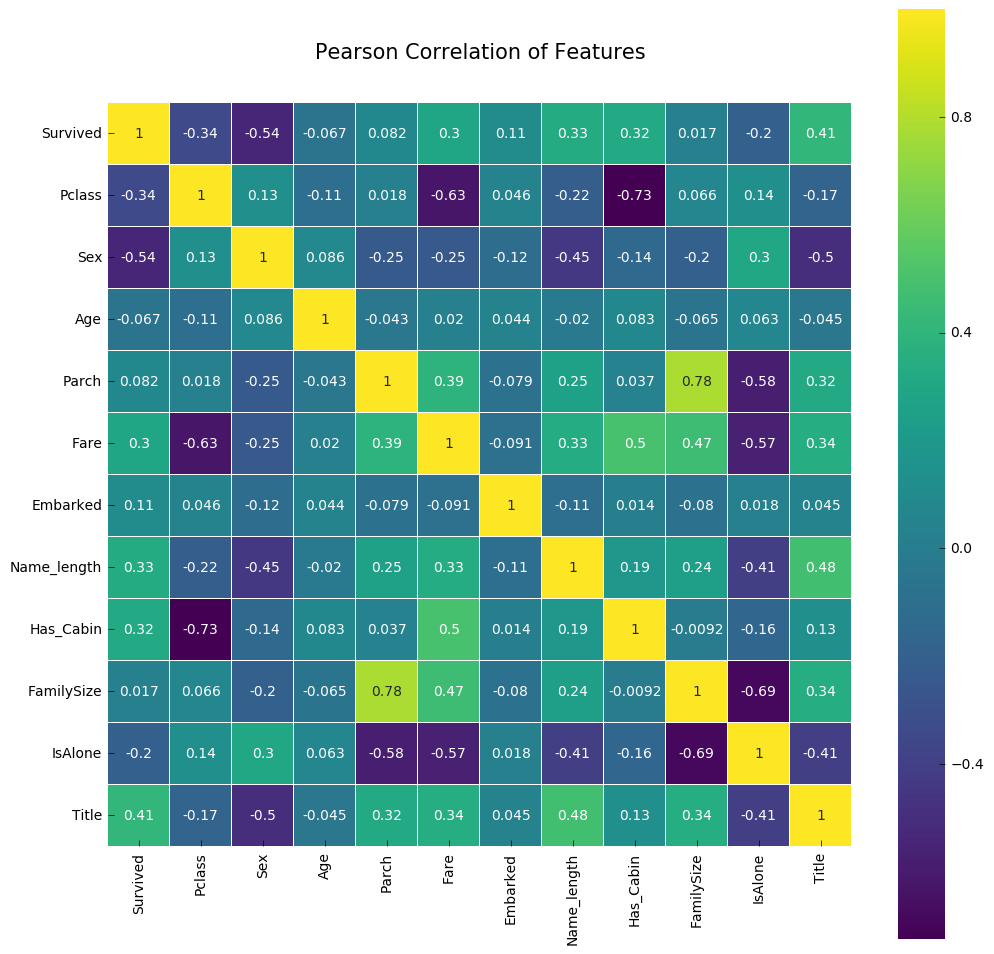

In [5]:
#상관관계를 살펴보자.
# Pandas에서 corr()를 통해서 상관계수를 알수 있다.
# 1, -1에 가까울수록 양과 음의 선형관계를 갖는다.
# 0이면 선형관계가 없다.
# 아래에서 Parch와 Failimy size가 상관관계가 높다.
# 각변수들 간에 중복되거나 불필요한 정보가 없다.


colormap = plt.cm.viridis #color map 생성
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
#print(train.astype(float).corr())
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

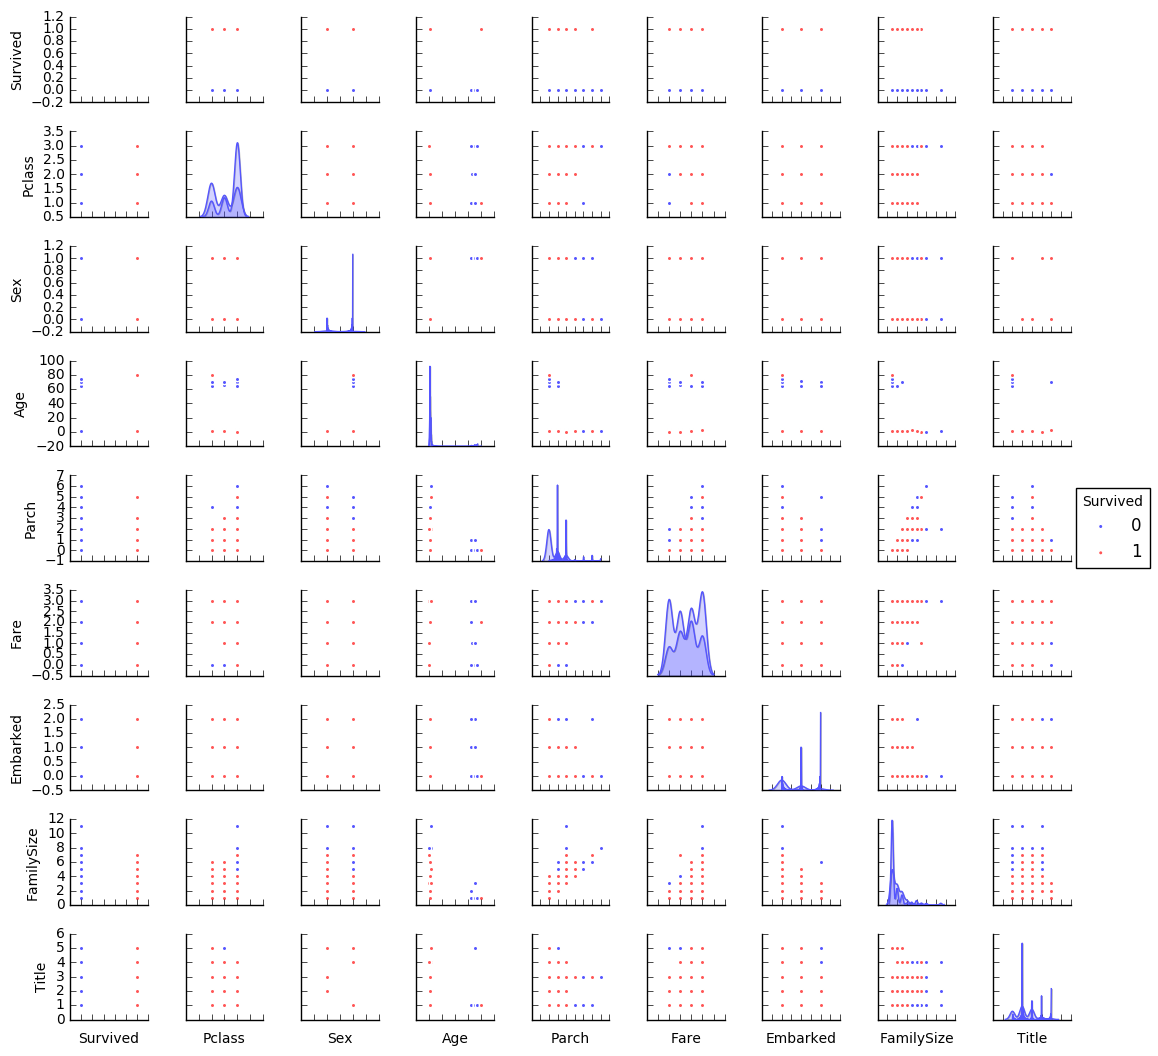

In [6]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

# Helper class & Kfold

 - 여러 classfier를 사용하기 위한 helper 클래스를 만든다.
 

In [7]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        fi = self.clf.fit(x,y).feature_importances_
        print(fi)
        return fi
    
# Class to extend XGboost classifer

#  Kfold Train
 - 트레인을 시켜줄 메소드를 만든다. 
 - Kfold를 사용하여 트레인 데이터를 여러개로 나누어서 트레이닝 한다.

In [8]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    print(kf)
    print(x_train.shape)
    print(type(x_train))

    for i, (train_index, test_index) in enumerate(kf):
        #print(train_index)
        print(train_index.shape)
        #print(x_train.shape)
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)




# ensemble model parameter
- 총 모델은 5개
- Random forest
- Extra Tree
- AdaBoost
- Gradient Boosting
- svc

In [9]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

# Make model using helper
- Helerp로 모델을 만든다.
- 훈련 Set을 만든다. Survivied는 label이므로 제거

In [10]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [11]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

# Training
- 훈련 을 시작한다.

In [12]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

sklearn.cross_validation.KFold(n=891, n_folds=5, shuffle=False, random_state=0)
(891, 11)
<class 'numpy.ndarray'>
(712,)
(713,)
(713,)
(713,)
(713,)
sklearn.cross_validation.KFold(n=891, n_folds=5, shuffle=False, random_state=0)
(891, 11)
<class 'numpy.ndarray'>
(712,)
(713,)
(713,)
(713,)
(713,)
sklearn.cross_validation.KFold(n=891, n_folds=5, shuffle=False, random_state=0)
(891, 11)
<class 'numpy.ndarray'>
(712,)
(713,)
(713,)
(713,)
(713,)
sklearn.cross_validation.KFold(n=891, n_folds=5, shuffle=False, random_state=0)
(891, 11)
<class 'numpy.ndarray'>
(712,)
(713,)
(713,)
(713,)
(713,)
sklearn.cross_validation.KFold(n=891, n_folds=5, shuffle=False, random_state=0)
(891, 11)
<class 'numpy.ndarray'>
(712,)
(713,)
(713,)
(713,)
(713,)
Training is complete


# Explore feature 
- 모델별로 중요한 Feature를 뽑아 본다.
- help class에서 중요 Feature를 뽑는 메소드 사용

In [13]:
rf_features = rf.feature_importances(x_train,y_train)
et_features = et.feature_importances(x_train, y_train)
ada_features = ada.feature_importances(x_train, y_train)
gb_features = gb.feature_importances(x_train,y_train)

[ 0.12559164  0.19886386  0.03178151  0.02081382  0.07143725  0.02353143
  0.10882815  0.06398104  0.06707709  0.01402978  0.27406443]
[ 0.11983125  0.37778252  0.02331702  0.01776885  0.05595324  0.02747421
  0.04710364  0.08437646  0.0457487   0.02200278  0.17864131]
[ 0.026  0.01   0.02   0.064  0.04   0.01   0.696  0.014  0.048  0.006
  0.066]
[ 0.079817    0.03925831  0.10833325  0.02765828  0.11158574  0.05918562
  0.37464367  0.02081104  0.06674455  0.02257185  0.08939069]


# Feature import를 Plotting 하게 Dataframe에 저장

In [17]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

print(feature_dataframe)

    AdaBoost feature importances  Extra Trees  feature importances  \
0                          0.028                          0.119685   
1                          0.012                          0.379309   
2                          0.020                          0.019269   
3                          0.072                          0.016695   
4                          0.044                          0.056688   
5                          0.010                          0.027951   
6                          0.678                          0.046456   
7                          0.014                          0.085853   
8                          0.050                          0.044973   
9                          0.002                          0.021679   
10                         0.070                          0.181441   

    Gradient Boost feature importances  Random Forest feature importances  \
0                             0.073620                           0.126568   
1    

# plotting

In [18]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


In [19]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


In [20]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


In [21]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]



layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Adding New Feature

In [23]:
# Create the new column containing the average of values
print(feature_dataframe.shape)
print(feature_dataframe.head(2))

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise 가로로 더함
feature_dataframe.head(10)

(11, 6)
   AdaBoost feature importances  Extra Trees  feature importances  \
0                         0.028                          0.119685   
1                         0.012                          0.379309   

   Gradient Boost feature importances  Random Forest feature importances  \
0                            0.073620                           0.126568   
1                            0.031163                           0.201584   

  features      mean  
0   Pclass  0.086968  
1      Sex  0.156014  


,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.028,0.119685,0.073620,0.126568,Pclass,0.086968
1,0.012,0.379309,0.031163,0.201584,Sex,0.156014
2,0.020,0.019269,0.087744,0.028925,Age,0.038985
3,0.072,0.016695,0.024354,0.020777,Parch,0.033457
4,0.044,0.056688,0.102328,0.071357,Fare,0.068594
5,0.010,0.027951,0.061991,0.024699,Embarked,0.031160
6,0.678,0.046456,0.417880,0.109847,Name_length,0.313046
7,0.014,0.085853,0.027988,0.063908,Has_Cabin,0.047937
8,0.050,0.044973,0.069017,0.067241,FamilySize,0.057808
9,0.002,0.021679,0.023410,0.013694,IsAlone,0.015196


In [24]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

# Second level Model predicting
 - 두번째 모델의 training set 구축

In [25]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
print(base_predictions_train.head())
print(base_predictions_train.shape)

   AdaBoost  ExtraTrees  GradientBoost  RandomForest
0       0.0         0.0            0.0           0.0
1       1.0         1.0            1.0           1.0
2       1.0         0.0            1.0           0.0
3       1.0         1.0            1.0           1.0
4       0.0         0.0            0.0           0.0
(891, 4)


# 1층 모델의 각각 Train set별 확률 확인


In [26]:
#각 모델별 확률을 보자
train_results_xgb
#랜덤 포레스트 Train Data확률
trainprediction_rf = pd.DataFrame({ 'PassengerId': train_passengerid,
                            'Survived_rfp': rf_oof_train.ravel() })
trainprediction_rf_merge = train_results_xgb.merge(trainprediction_rf, how='left', on='PassengerId')
#print(trainprediction_rf_merge.columns)
trainprediction_rf_merge['result'] = trainprediction_rf_merge[['Survived','Survived_rfp']].apply(lambda x : 1 if x['Survived'] == x['Survived_rfp'] else 0, axis = 1)
print('random forest {0}'.format(trainprediction_rf_merge['result'].sum(axis=0)/ len(train_results_xgb.index)) )

#extra tree Train Data확률
trainprediction_et = pd.DataFrame({ 'PassengerId': train_passengerid,
                             'Survived_etp': et_oof_train.ravel() })
trainprediction_et_merge = train_results_xgb.merge(trainprediction_et, how='left', on='PassengerId')
trainprediction_et_merge['result'] = trainprediction_et_merge[['Survived','Survived_etp']].apply(lambda x : 1 if x['Survived'] == x['Survived_etp'] else 0, axis = 1)
print('extra forest {0}'.format(trainprediction_et_merge['result'].sum(axis=0)/ len(train_results_xgb.index)) )


#ada boost Train Data확률
trainprediction_ad = pd.DataFrame({ 'PassengerId': train_passengerid,
                             'Survived_adp': ada_oof_train.ravel() })
trainprediction_ad_merge = train_results_xgb.merge(trainprediction_ad, how='left', on='PassengerId')
# print(trainprediction_et_merge.columns)
trainprediction_ad_merge['result'] = trainprediction_ad_merge[['Survived','Survived_adp']].apply(lambda x : 1 if x['Survived'] == x['Survived_adp'] else 0, axis = 1)
print('ada {0}'.format(trainprediction_ad_merge['result'].sum(axis=0)/ len(train_results_xgb.index)) )

#gradient Train Data확률
trainprediction_gb = pd.DataFrame({ 'PassengerId': train_passengerid,
                             'Survived_gbp': gb_oof_train.ravel() })
trainprediction_gb_merge = train_results_xgb.merge(trainprediction_gb, how='left', on='PassengerId')
# print(trainprediction_et_merge.columns)
trainprediction_gb_merge['result'] = trainprediction_gb_merge[['Survived','Survived_gbp']].apply(lambda x : 1 if x['Survived'] == x['Survived_gbp'] else 0, axis = 1)
print('gb {0}'.format(trainprediction_gb_merge['result'].sum(axis=0)/ len(train_results_xgb.index)) )




#gradient Train Data확률
trainprediction_svc = pd.DataFrame({ 'PassengerId': train_passengerid,
                             'Survived_svp': svc_oof_train.ravel() })
trainprediction_svc_merge = train_results_xgb.merge(trainprediction_svc, how='left', on='PassengerId')
# print(trainprediction_et_merge.columns)
trainprediction_svc_merge['result'] = trainprediction_svc_merge[['Survived','Survived_svp']].apply(lambda x : 1 if x['Survived'] == x['Survived_svp'] else 0, axis = 1)
print('svc {0}'.format(trainprediction_svc_merge['result'].sum(axis=0)/ len(train_results_xgb.index)) )





random forest 0.8641975308641975
extra forest 0.8226711560044894
ada 0.8069584736251403
gb 0.8069584736251403
svc 0.813692480359147


# 2차 모델 data간의 상관계수 분석
 - 모델간의 상관계수가 적은것을 stacking 해야지 확률이 더 높아짐

In [27]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Portland',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

# Make train set
- 각 모델별 예측 결과를 2차 모델의 인풋으로 설정

In [28]:
x_train_xgb = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test_xgb = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

print(x_train_xgb)

[[ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 0.  0.  1.  1.  1.]
 ..., 
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


# Second level Model is Xgboost
 - n_estimators : 분류기
 - max_depth : 트리 최대깊이
 - min_child_weight : Defines the minimum sum of weights of all observations required in a child.
 - eta : learning rates 트리가 깊을수록 오버피팅이 일어나므로 가지를 늘릴때마다 Weight를 주어 과적합이 안되게 방지
 - gamma : 감마가 커지면 트리의 깊이가 얇아짐
 - objective : 목적함수 Learning 할때 사용


 . https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/


In [29]:

gbm = xgb.XGBClassifier(
 #eta = 0.01,
 n_estimators= 3000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train_xgb, y_train)
predictions = gbm.predict(x_test_xgb)
train_prediction = gbm.predict(x_train_xgb)

# XGBoost로 예측

In [30]:
trainprediction_xgb = pd.DataFrame({ 'PassengerId': train_passengerid,
                            'Survived_xgp': train_prediction })

trainprediction_xgb_merge = train_results_xgb.merge(trainprediction_xgb, how='left', on='PassengerId')

trainprediction_xgb_merge['result'] = trainprediction_xgb_merge[['Survived','Survived_xgp']].apply(lambda x : 1 if x['Survived'] == x['Survived_xgp'] else 0, axis = 1)


print("Xgboost {0}".format(trainprediction_xgb_merge['result'].sum(axis=0)/ len(train_results_xgb.index) ))

Xgboost 0.867564534231201
